<a href="https://colab.research.google.com/github/Alexandra-Smith/FruitPunch_AI_Bootcamp/blob/main/FP_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Poachers detection challenge for FP AI in Practice Bootcamp

by Alexandra Smith

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import numpy as np
import cv2

# Step 0
## Loading the data

In [ ]:
# Connect directory to notebook and navigate to where data is stored

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to data within drive
DATA_PATH = '/content/drive/MyDrive/Poacher detection/Labeled data/'
IMAGES_PATH = DATA_PATH + 'images/'
LABELS_PATH = DATA_PATH + 'annotations/'

In [ ]:
# Get paths to IMAGE directories
TRAIN_IMAGES_PATH = IMAGES_PATH + 'train/'
TEST_IMAGES_PATH = IMAGES_PATH + 'test/'
VAL_IMAGES_PATH = IMAGES_PATH + 'val/'

TRAIN_LABELS = LABELS_PATH + 'instances_train.json'
TEST_LABELS = LABELS_PATH + 'instances_test.json'
VAL_LABELS = LABELS_PATH + 'instances_val.json'

# Step 1
## Analysing the data

### Images

In [ ]:
# View some train images
plt.figure(figsize=(10, 10))
TRAIN_IMAGES = os.listdir(TRAIN_IMAGES_PATH)
for i in range(9):
  img_path = TRAIN_IMAGES_PATH + TRAIN_IMAGES[i]
  ax = plt.subplot(3, 3, i + 1)
  img = cv2.imread(img_path, )
  plt.imshow(img, cmap='gray')
  plt.axis("off")

### Annotations

Helpful resource: https://medium.com/mlearning-ai/coco-dataset-what-is-it-and-how-can-we-use-it-e34a5b0c6ecd

In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycocotools.coco import COCO
import skimage.io as io
from pathlib import Path

In [ ]:
# Analyse training annotations
coco = COCO(TRAIN_LABELS) # return dictionary of the dataset
img_IDs = coco.getImgIds() # get image IDs
imgs = coco.loadImgs(img_IDs[110:113]) # load images

loading annotations into memory...
Done (t=3.59s)
creating index...
index created!


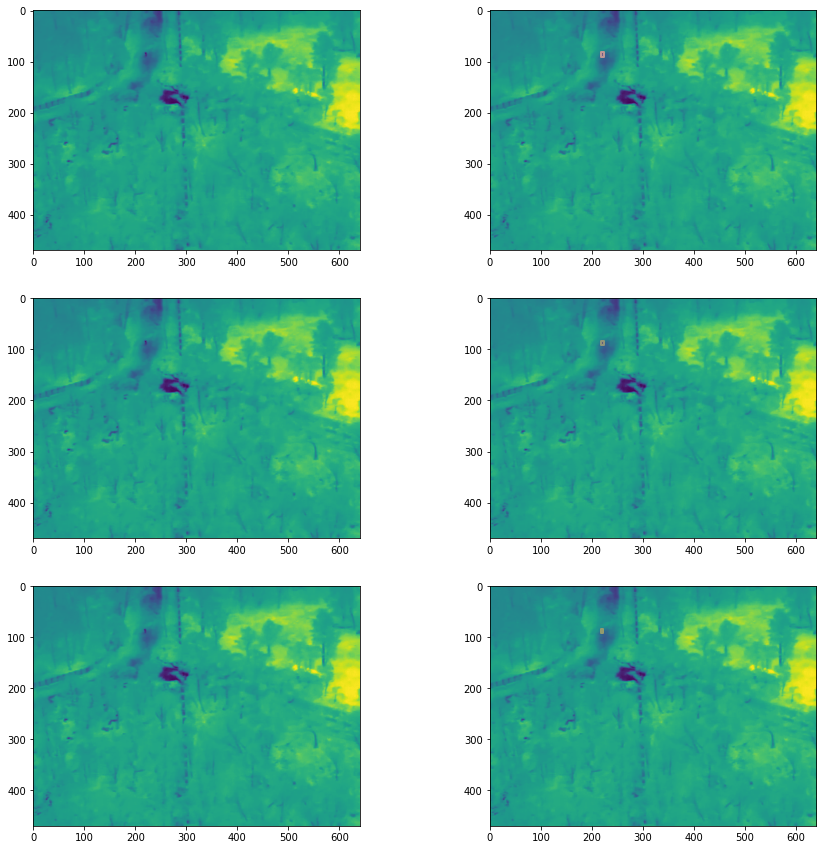

In [ ]:
# Visualise images and annotations
_, axs = plt.subplots(len(imgs), 2, figsize=(15, 15))
for img, ax in zip(imgs, axs):
    I = io.imread(Path(TRAIN_IMAGES_PATH)/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

# Step 2
## Model

Implementing Detectron2 model from Meta: 

https://www.analyticsvidhya.com/blog/2021/08/your-guide-to-object-detection-with-detectron2-in-pytorch/
https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=0d288Z2mF5dC

In [ ]:
!python -m pip install pyyaml==5.1
import sys, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


In [ ]:
# import detectron2 modules
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

import json, random

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, TRAIN_LABELS, TRAIN_IMAGES_PATH)
register_coco_instances("my_dataset_test", {}, TEST_LABELS, TEST_IMAGES_PATH)
register_coco_instances("my_dataset_val", {}, VAL_LABELS, VAL_IMAGES_PATH)

In [72]:
# get dictionary of filename and image ids
def get_filenames(filename_dict, json_file):
    with open(json_file) as f:
      imgs_anns = json.load(f)
    for idx in imgs_anns["images"]:
      filename = idx["file_name"]
      img_id = idx["id"]
      filename_dict[img_id] = filename
    return filename_dict

filename_dict = {}
get_filenames(filename_dict, TRAIN_LABELS)
get_filenames(filename_dict, TEST_LABELS)
get_filenames(filename_dict, VAL_LABELS)

{124: 'video53_1_000123.PNG',
 125: 'video53_1_000124.PNG',
 126: 'video53_1_000125.PNG',
 127: 'video53_1_000126.PNG',
 128: 'video53_1_000127.PNG',
 129: 'video53_1_000128.PNG',
 131: 'video53_1_000130.PNG',
 133: 'video53_1_000132.PNG',
 134: 'video53_1_000133.PNG',
 135: 'video53_1_000134.PNG',
 136: 'video53_1_000135.PNG',
 137: 'video53_1_000136.PNG',
 138: 'video53_1_000137.PNG',
 139: 'video53_1_000138.PNG',
 140: 'video53_1_000139.PNG',
 141: 'video53_1_000140.PNG',
 142: 'video53_1_000141.PNG',
 143: 'video53_1_000142.PNG',
 144: 'video53_1_000143.PNG',
 145: 'video53_1_000144.PNG',
 147: 'video53_1_000146.PNG',
 148: 'video53_1_000147.PNG',
 149: 'video53_1_000148.PNG',
 150: 'video53_1_000149.PNG',
 151: 'video53_1_000150.PNG',
 152: 'video53_1_000151.PNG',
 154: 'video53_1_000153.PNG',
 155: 'video53_1_000154.PNG',
 156: 'video53_1_000155.PNG',
 157: 'video53_1_000156.PNG',
 158: 'video53_1_000157.PNG',
 159: 'video53_1_000158.PNG',
 160: 'video53_1_000159.PNG',
 161: 'vid

In [73]:
# visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

[12/11 16:12:52 d2.data.datasets.coco]: Loaded 13111 images in COCO format from /content/drive/MyDrive/Poacher detection/Labeled data/annotations/instances_train.json


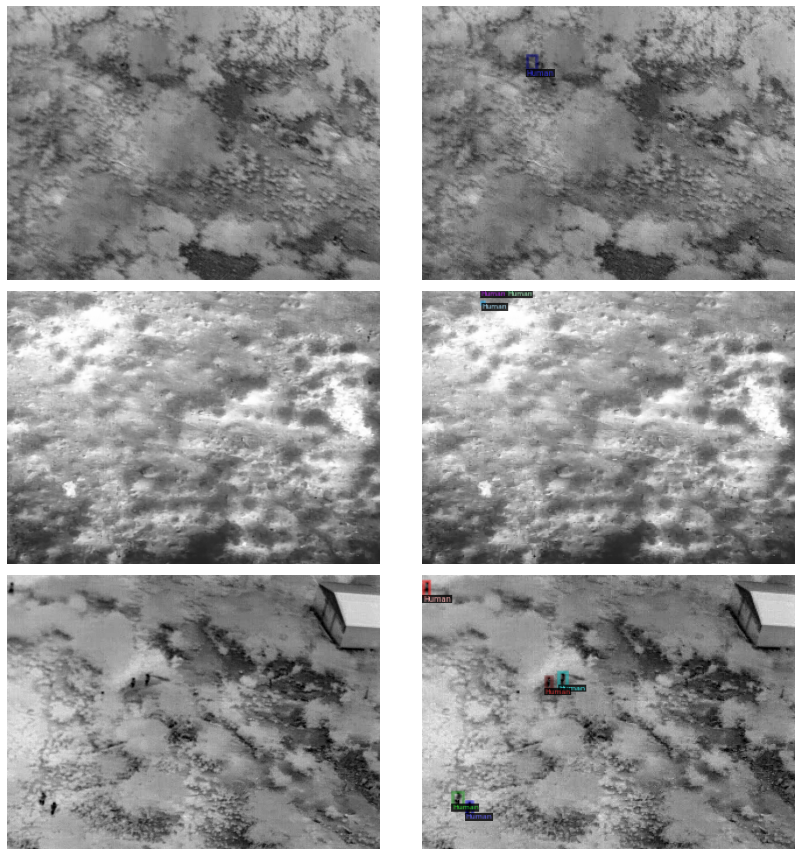

In [74]:
# view some examples of training data to make sure the data has imported correctly

from google.colab.patches import cv2_imshow

_, axs = plt.subplots(len(imgs), 2, figsize=(12, 12))
for d, ax in zip(random.sample(dataset_dicts, 3), axs):
    id = d["image_id"]
    filename = filename_dict[id]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    # cv2_imshow(vis.get_image()[:, :, ::-1])
    ax[0].imshow(img); ax[0].axis('off')
    ax[1].imshow(vis.get_image()[:, :, ::-1]); ax[1].axis('off')
    plt.tight_layout()

## Training

- fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the custom dataset

In [81]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.TEST.EVAL_PERIOD = 500

In [76]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [82]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/11 16:15:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[12/11 16:15:58 d2.engine.train_loop]: Starting training from iteration 0
ERROR [12/11 16:16:01 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/content/detectron2/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/content/detectron2/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/content/detectron2/detectron2/engine/train_loop.py", line 274, in run_step
    loss_dict = self.model(data)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/content/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 158, in forward
    features = self.backbone(images.tensor)
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/content/detectron2/detectron2/modeling/backbone/fpn.py", line 

OutOfMemoryError: ignored